In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from math import log10
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

In [2]:
train_dir = os.path.realpath("../assets/annotated-corpus/train")
result_dir = os.path.realpath("../assets/wordcount/train")

In [3]:
topics = os.listdir(train_dir)
topics

['1', '2', '3', '4']

# Task 1

In [4]:
def get_stems_processed(filepath):
    sentences = []
    pattern = r"([A-Za-z]+[-.@]?)+\w*\.?"
    with open(filepath) as f:
        lines = "".join(f.readlines())
        sentences_raw = lines.split("\n\n")
        for s in sentences_raw:
            stems = []
            words = s.split("\n")
            if len(words) == 0 or words[0] == "":
                continue
            stems_raw = list(map(lambda x: x.split("\t")[1], words))
            lemmas = list(map(lambda x: x.split("\t")[2], words))
            for i in range(len(stems_raw)):
                if lemmas[i] not in stopwords.words("english") and re.match(pattern, lemmas[i]) is not None:
                    stems.append(stems_raw[i])
            sentences.append(stems)
    return sentences

In [5]:
def count_words_in_sentences(sentences):
    word_count = {}
    sentences_count = []
    for sentence in sentences:
        wbs_count = {}
        for w in sentence:
            if w not in wbs_count.keys():
                wbs_count[w] = 0
            wbs_count[w] += 1
            if w not in word_count.keys():
                word_count[w] = 0
            word_count[w] += 1
        sentences_count.append(wbs_count)
    return word_count

In [6]:
import datetime

all_documents = []
word_dict_raw = {}
cntr = 0
total_len = 0
for t in topics:
    total_len += len(os.listdir(os.path.join(train_dir, t)))
print(f"Total files for process: {total_len}")

for t in topics:
    workdir = os.path.join(train_dir, t)
    start_time = datetime.datetime.now()
    for filename in os.listdir(workdir):
        stems = get_stems_processed(os.path.join(workdir, filename))
        all_documents.append(stems)
        counts = count_words_in_sentences(stems)
        for w in counts.keys():
            if w not in word_dict_raw.keys():
                word_dict_raw[w] = 0
            word_dict_raw[w] += counts[w]
        cntr += 1
        if cntr % 1000 == 0:
            print(f"Processed {cntr} files. 1000 files per: {(datetime.datetime.now() - start_time).total_seconds()}s")
            start_time = datetime.datetime.now()

Total files for process: 120000
Processed 1000 files. 1000 files per: 34.737349s
Processed 2000 files. 1000 files per: 23.597014s
Processed 3000 files. 1000 files per: 19.337387s
Processed 4000 files. 1000 files per: 18.216569s
Processed 5000 files. 1000 files per: 15.170497s
Processed 6000 files. 1000 files per: 14.569158s
Processed 7000 files. 1000 files per: 14.57633s
Processed 8000 files. 1000 files per: 14.470864s
Processed 9000 files. 1000 files per: 14.591524s
Processed 10000 files. 1000 files per: 14.376304s
Processed 11000 files. 1000 files per: 14.362876s
Processed 12000 files. 1000 files per: 14.746865s
Processed 13000 files. 1000 files per: 14.700675s
Processed 14000 files. 1000 files per: 14.21825s
Processed 15000 files. 1000 files per: 14.295133s
Processed 16000 files. 1000 files per: 14.657657s
Processed 17000 files. 1000 files per: 14.38588s
Processed 18000 files. 1000 files per: 14.570852s
Processed 19000 files. 1000 files per: 14.646748s
Processed 20000 files. 1000 fi

In [7]:
word_dict = dict(word_dict_raw)

for w in word_dict_raw.keys():
    if word_dict_raw[w] < 3:
        del word_dict[w]

In [8]:
if not os.path.isdir(result_dir):
    os.makedirs(result_dir, exist_ok=True)
with open(os.path.join(result_dir, "dictionary.json"), "w") as f:
    json.dump(word_dict, f, indent=1)

In [191]:
doc_names = []
matrix_arr = []
cnt = 0
for t in topics:
    workdir = os.path.join(train_dir, t)
    start_time = datetime.datetime.now()
    for filename in os.listdir(workdir):
        doc_names.append(t + "/" + filename)
        stems = get_stems_processed(os.path.join(workdir, filename))
        counts = count_words_in_sentences(stems)
        vec = []
        for w in word_dict.keys():
            if w in counts.keys():
                vec.append(counts[w])
            else:
                vec.append(0)
        matrix_arr.append(vec)
        if sum(vec) == 0:
            print("Zero vector for document", filename)
        cnt += 1
        if cnt % 1000 == 0:
            print(f"Processed {cnt} files. 1000 Files Per: {(datetime.datetime.now() - start_time).total_seconds()}s")
            start_time = datetime.datetime.now()


Processed 1000 files. 1000 Files Per: 12.160512s
Processed 2000 files. 1000 Files Per: 12.18704s
Processed 3000 files. 1000 Files Per: 16.435404s
Processed 4000 files. 1000 Files Per: 14.748235s
Processed 5000 files. 1000 Files Per: 14.950337s
Processed 6000 files. 1000 Files Per: 18.305409s
Processed 7000 files. 1000 Files Per: 14.43797s
Processed 8000 files. 1000 Files Per: 14.86086s
Processed 9000 files. 1000 Files Per: 15.588874s
Processed 10000 files. 1000 Files Per: 14.100073s
Processed 11000 files. 1000 Files Per: 13.400248s
Processed 12000 files. 1000 Files Per: 15.122078s
Processed 13000 files. 1000 Files Per: 14.088672s
Processed 14000 files. 1000 Files Per: 14.276741s
Processed 15000 files. 1000 Files Per: 16.00925s
Processed 16000 files. 1000 Files Per: 15.271889s
Processed 17000 files. 1000 Files Per: 18.820368s
Processed 18000 files. 1000 Files Per: 20.164487s
Processed 19000 files. 1000 Files Per: 19.473286s
Processed 20000 files. 1000 Files Per: 17.522625s
Processed 210

In [211]:
m_len = len(matrix_arr)
m_1 = pd.DataFrame(matrix_arr[:int(m_len/4)])
m_1.columns = word_dict.keys()
m_1.index = doc_names[:int(m_len/4)]

KeyboardInterrupt: 

In [ ]:
m_1.to_csv(os.path.join(result_dir, "term-document.csv"))

In [214]:
m_len = len(matrix_arr)
m_1 = pd.DataFrame(matrix_arr[int(3*m_len/4):])
m_1.columns = word_dict.keys()
m_1.index = doc_names[int(3*m_len/4):]
m_1.to_csv(os.path.join(result_dir, "term-document.csv"), mode="a", header=False)

In [202]:
matrix = pd.DataFrame(matrix_arr)
matrix.columns = word_dict.keys()
matrix.index = doc_names

MemoryError: Unable to allocate 5.56 GiB for an array with shape (120000, 6218) and data type object

In [ ]:
matrix.to_csv(os.path.join(result_dir, "term-document.csv"))

# Task 2

In [9]:
def tf_idf(words, matrix):
    total_words = sum(words.values())
    total_documents = len(matrix.index)
    result = []
    for w in matrix.columns:
        if w not in words:
            result.append(0.0)
            continue
        t_f = words[w] / total_words
        d_f = sum(matrix[w] > 0)
        tfidf = t_f * (log10(total_documents + 1) - log10(d_f + 1))
        result.append(tfidf)
    return result

In [10]:
import os
import re
from nltk import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from pathlib import Path

In [11]:
def split_to_words(sentence):
    words = re.findall(r"\w+@\w+\.\w+|\+\d{1,3}-\d{3}-\d{3}-\d{2}-\d{2}|\w+", sentence)
    return words

In [12]:
def split_to_sent(text):
    text = re.sub(r"(?<=&lt;).*?(?=&gt;)", " ", text)
    text = re.sub(r"&gt;", " ", text)
    text = re.sub(r"&lt;", " ", text)
    sentences = re.split(
        r"(((?<!\w\.\w.)(?<!\s\w\.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s(?=[A-Z]))|((?<![\,\-\:])\n(?=[A-Z]|\" )))", text)[
                ::4]
    return sentences

In [13]:
def preprocess_text(text, by_sentences=False):
    stemmer = SnowballStemmer("english")
    lemmatizer = WordNetLemmatizer()
    sentences = split_to_sent(text)
    result = []
    for s in sentences:
        sentence = []
        for w in split_to_words(s):
            w_processed = re.sub(r"[.!?,]$", "", w).lower()
            if lemmatizer.lemmatize(w_processed) not in stopwords.words("english"):
                sentence.append(stemmer.stem(w_processed))
        if by_sentences:
            result.append(sentence)
        else:
            result += sentence
    return result

In [14]:
def vectorize_tf_idf(text, matrix):
    preprocessed = preprocess_text(text)
    text_dict = count_words_in_sentences([preprocessed])
    return tf_idf(text_dict, matrix)

In [15]:
matrix = pd.read_csv(os.path.join(result_dir, "term-document.csv"), index_col=0)

In [16]:
t1 = """Evolution Designs sell the "Darwin fish".  It's a fish symbol, like the ones
Christians stick on their cars, but with feet and the word "Darwin" written
inside.  The deluxe moulded 3D plastic fish is $4.95 postpaid in the US."""

In [17]:
t2 = """A story based on the premise that the US Congress is mysteriously
assassinated, and fundamentalists quickly take charge of the nation to set it
"right" again.  The book is the diary of a woman's life as she tries to live
under the new Christian theocracy.  Women's right to own property is revoked,
and their bank accounts are closed; sinful luxuries are outlawed, and the
radio is only used for readings from the Bible.  Crimes are punished
retroactively: doctors who performed legal abortions in the "old world" are
hunted down and hanged.  Atwood's writing style is difficult to get used to
at first, but the tale grows more and more chilling as it goes on."""

In [18]:
vectorize_tf_idf(t1, matrix)[:100]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.07201380727389917,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [19]:
vectorize_tf_idf(t2, matrix)[:100]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.029751089129029136,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.025625816488124634,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02026599618583556,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

# Task 3

In [20]:
w2v = Word2Vec(sentences=[sentence for document in all_documents for sentence in document], epochs=40)
w2v.save(os.path.join(train_dir, "..", "w2v_weights"))

In [21]:
w2v.wv.most_similar("christian")

[('cathol', 0.5365188121795654),
 ('devout', 0.5312540531158447),
 ('chesnot', 0.4825665354728699),
 ('canterburi', 0.48174959421157837),
 ('church', 0.4620301425457001),
 ('pope', 0.4593251943588257),
 ('laettner', 0.45599958300590515),
 ('duca', 0.4544411897659302),
 ('vieri', 0.44649961590766907),
 ('becker', 0.439924031496048)]

# Task 4

In [22]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [23]:
cosine_similarity(w2v.wv["christian"], w2v.wv["politician"])

0.36233634

In [24]:
def draw_words(terms, vectors_source):
    pca = PCA(n_components=2)
    vectors_2d = pd.DataFrame(pca.fit_transform([vectors_source[term] for term in terms]))
    vectors_2d.index = terms
    vectors_2d.columns = ["x", "y"]
    p = sns.scatterplot(data=vectors_2d, x="x", y="y")

    for i in vectors_2d.index:
        item = vectors_2d.loc[i]
        p.text(item.x, item.y, i)
    return p

<AxesSubplot:xlabel='x', ylabel='y'>

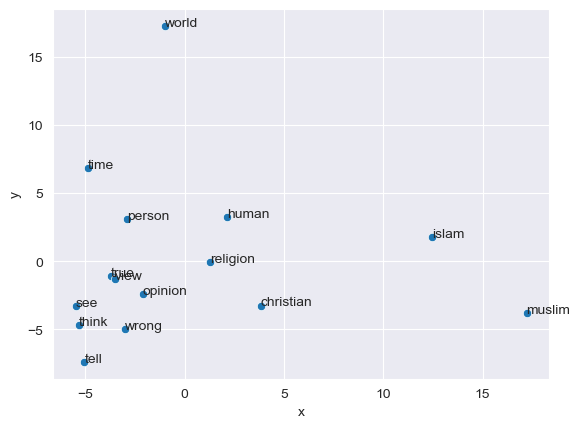

In [25]:
terms_to_check = ["christian", "muslim", "islam", "time", "world", "true",
                  "wrong", "human", "person", "tell", "see", "opinion", "think", "view", "religion"]
draw_words(terms_to_check, w2v.wv)

# Task 5

In [26]:
def transform_to_compare(vectors):
    pca = PCA(n_components=len(w2v.wv[0]))
    transformed = pca.fit_transform(vectors)
    return transformed

In [27]:
terms_vectorized = [vectorize_tf_idf(i, matrix) for i in matrix.columns]

# Task 6

In [28]:
to_cmp = transform_to_compare(terms_vectorized)

In [29]:
terms_to_compare = pd.DataFrame(to_cmp)
terms_to_compare.index = matrix.columns

In [30]:
def compare_methods(w1, w2):
    print("Results for words", w1, "and", w2)
    print("W2V:", cosine_similarity(w2v.wv[w1], w2v.wv[w2]))
    print("Tf-Idf:", cosine_similarity(terms_to_compare.loc[w1], terms_to_compare.loc[w2]))
    print()

In [31]:
compare_methods("time", "muslim")
compare_methods("say", "tell")
compare_methods("person", "time")

Results for words time and muslim
W2V: -0.13441443
Tf-Idf: 0.9988986318325437

Results for words say and tell
W2V: 0.64280057
Tf-Idf: 0.9980211883786051

Results for words person and time
W2V: 0.22495331
Tf-Idf: 0.9996011998239979


In [32]:
tfidf_data = {}
for i in range(len(matrix.columns)):
    tfidf_data[matrix.columns[i]] = terms_vectorized[i]

<AxesSubplot:xlabel='x', ylabel='y'>

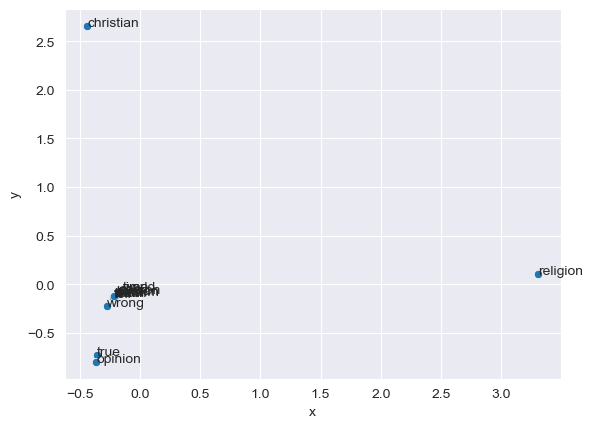

In [33]:
draw_words(terms_to_check, tfidf_data)

# Task 7

In [34]:
def vectorize(sentences, w2v):
    result_vec = np.zeros(w2v.vector_size)
    for s in sentences:
        sentence_vec = np.zeros(w2v.vector_size)
        for w in s:
            if w2v.wv.has_index_for(w):
                sentence_vec += w2v.wv[w]
        sentence_vec = sentence_vec / len(s) if len(s) > 0 else np.zeros(w2v.vector_size)
        result_vec += sentence_vec
    result_vec = result_vec / len(sentences) if len(sentences) > 0 else np.zeros(w2v.vector_size)
    return result_vec

In [35]:
preprocess_text(t1, True)

[['evolut',
  'design',
  'sell',
  'darwin',
  'fish',
  'fish',
  'symbol',
  'like',
  'one'],
 ['christian',
  'stick',
  'car',
  'feet',
  'word',
  'darwin',
  'written',
  'insid',
  'delux',
  'mould',
  '3d',
  'plastic',
  'fish',
  '4',
  '95',
  'postpaid',
  'us']]

In [36]:
vectorize(preprocess_text(t1, True), w2v)

array([-0.61716539, -0.09720683,  0.20117598,  0.11210588, -0.44843442,
       -0.22371527,  0.59126214,  0.22266231, -0.34861236, -0.07772593,
       -0.24463488, -0.31253492, -0.05768895, -0.72058062, -0.34076974,
       -0.76761443,  0.21472387,  0.38699245, -0.10278071, -0.14707191,
        0.83177092, -0.42763585, -0.21895555,  0.19870429,  0.57872711,
       -0.18278595, -0.47269855, -0.34106249,  0.2486803 ,  0.51570295,
        0.47754321,  0.20432898,  0.30520501,  0.48427061, -0.40446676,
        1.01076176, -0.26457323,  0.30873169, -0.28713756, -0.57976236,
        0.51354063, -0.0861626 ,  0.77506607,  0.23444437,  0.13789807,
        0.2842686 , -0.02537989,  0.22153247, -0.65283671,  0.31433313,
       -0.08159082, -0.57425156,  0.27752921, -0.46222388,  0.37769223,
       -0.35936638,  0.00944828,  0.17914666, -0.10678736, -0.19000884,
       -0.41625943, -0.26557376, -0.16251822, -0.13691936, -0.94887959,
        0.02305152,  0.45031578,  0.49620253, -0.11132001,  0.53

 # Task 8

In [37]:
w2v = Word2Vec.load(os.path.join(train_dir, "..", "w2v_weights"))
vectorized_documents = {}
for t in topics:
    workdir = os.path.join(train_dir, t)
    for filename in os.listdir(workdir):
        stems = get_stems_processed(os.path.join(workdir, filename))
        vectorized_documents[os.path.join(t, filename)] = vectorize(stems, w2v)

In [38]:
with open(os.path.join(train_dir, "..", "train_embeddings.tsv"), "w") as f:
    for k in vectorized_documents.keys():
        print(k.replace(".tsv", ""), *vectorized_documents[k], sep="\t", file=f)

In [40]:
test_dir = os.path.realpath("../assets/annotated-corpus/test")
vectorized_documents = {}
for t in topics:
    workdir = os.path.join(test_dir, t)
    for filename in os.listdir(workdir):
        stems = get_stems_processed(os.path.join(workdir, filename))
        vectorized_documents[os.path.join(t, filename)] = vectorize(stems, w2v)

In [41]:
with open(os.path.join(train_dir, "..", "test_embeddings.tsv"), "w") as f:
    for k in vectorized_documents.keys():
        print(k.replace(".tsv", ""), *vectorized_documents[k], sep="\t", file=f)